## Summary of task

- A Matlab file without any annotation is loaded and investigated (mostly based on its dimensions).
- Frequency on one sensor data is illustrated, then some filters were added (the filters were not mostly successful).
- Frequency data is limited to 0 to 50 Hz.
- The data are gather into a Pandas dataframe based on their labels (or more accurately postions), their timestamps and strain rates.
- These dataframe is then used for FFT and then scipy.signal.find_peaks is used to get the freaquencies with top picks.
- The initial results are not accurate enough when tried on one sample sensor; thus still there are some works to do:
  - Add some pre-processing such as a window to exclude outliers (I tried this now but it was not very efficient); I also tried some filters but they did not help;
  - working on the arguments of scipy.signal.find_peaks to hopefully remove them.

In [ ]:
!pip install hdf5storage

In [43]:
import scipy, os, hdf5storage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#### Explore the raw data, plot a sample FFT graph (pick one 300 mb file from here)

In [44]:
file_address = os.path.join(
    'sample', 'StrainRate_85-165meters_StartTime_2023-12-19_14-50-37.mat'
    )

mat = hdf5storage.loadmat(file_address)

In [45]:
# data seems to be located at StrainRate:

subsystem = mat['#subsystem#'][0][0][0]
DASsettings = mat['DASsettings'][0]
StrainRate = mat['StrainRate'][0]

In [47]:
# My guest on data structure:

data2 = StrainRate[2][0][0]; #dim: (101, 900000) seems 101 recorded data (at each timestep) by each sensor in wide formate
data5 = StrainRate[5][0]; # dim: (900000,) # seems timestamp
data1 = StrainRate[1][0]; # dim: (6,) # unknown maybe some metadata
data6 = StrainRate[6][0]; # dim: (6,) # unknown maybe some metadata
label = StrainRate[4][0][0][0][0]; # just an unknown label (seems FEA related)
data3 = np.squeeze(StrainRate[3][0][0]); # dim: (101,) # seems a position for each sensor

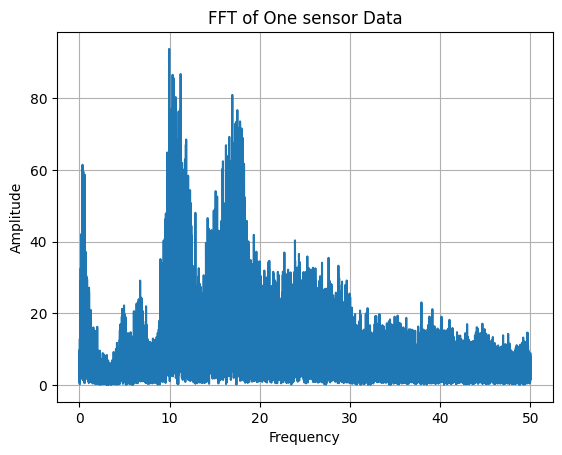

In [82]:
# Working on 1 sensor data (restricted to first 50 HZ):
# Assuming 'data2' the sensor data and 'data5' is the timestamp data.

# Selecting data from one sensor for FFT analysis
sensor_data = data2[0]

# Number of data points (assumed the length of the timestamp)
N = len(data5)
T = data5[1] - data5[0]
yf = scipy.fft.fft(sensor_data)
xf = scipy.fft.fftfreq(N, T)[:N//2]

indeces = xf < 50
yf = np.abs(yf[0:N//2][indeces])
xf = xf[indeces] 

plt.plot(xf, 2.0/N * yf)
plt.title('FFT of One sensor Data')
# plt.xlim(0,50)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

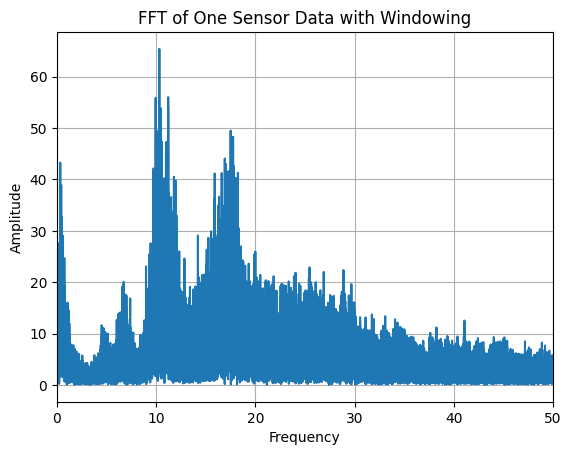

In [83]:
# applying a filter for example (this needs more work)

sensor_data = data2[0]
N = len(data5)
T = data5[1] - data5[0]

# np.hanning, np.hamming, np.blackman
window = np.hamming(N)  # Using Hanning window as an example
windowed_sensor_data = sensor_data * window

# FFT of the windowed data
yf = scipy.fft.fft(windowed_sensor_data)
xf = scipy.fft.fftfreq(N, T)[:N//2]

indeces = xf < 50

yf = np.abs(yf[0:N//2][indeces])
xf = xf[indeces] 

# Plotting
plt.plot(xf, 2.0/N * yf)
plt.title('FFT of One Sensor Data with Windowing')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 50)  # Limiting to 50 Hz as per your requirement
plt.show()


#### Create a python function that takes as an input a path to the raw data file and gives on the output a pandas.DataFrame with 3 columns: timestamp, label, value (The raw data might contain the data for multiple sensors in a "wide" format; convert it to "narrow").

In [56]:
def transformToDataframe(file_address):
    """
    Assumption:
    - data2 is the wide sensor data
    - data3 is sensors' labels
    - data5 is the timestamp

    :returns: DataFrame with columns 'timestamp', 'label', and 'value'.
    """

    mat = hdf5storage.loadmat(file_address)
    StrainRate = mat['StrainRate'][0]
    data2 = StrainRate[2][0][0]
    data5 = StrainRate[5][0]
    data3 = np.squeeze(StrainRate[3][0][0])

    
    num_sensors, num_timestamps = data2.shape
    narrow_data = data2.reshape(-1)

    repeated_timestamps = np.tile(data5, num_sensors)
    repeated_labels = np.repeat(data3, num_timestamps)

    # Create the DataFrame
    df = pd.DataFrame({
        'timestamp': repeated_timestamps,
        'label': repeated_labels,
        'value': narrow_data
    })

    return df

In [57]:
dataframe = transformToDataframe(file_address)
dataframe.head()

,timestamp,label,value
0,0.000,85.6,471.708008
1,0.001,85.6,207.158066
2,0.002,85.6,-641.408508
3,0.003,85.6,-550.619385
4,0.004,85.6,1407.755859


#### Create a python function that takes the data produced by the function above and computes the dominating frequencies. The suggested approach is to compute the FFT and select n peaks, where n can be also an input argument. Mind that there are multiple sensors, so we might need to consider a 2d FFT.

In [92]:
def getDominatingFrequencies(df, n_peaks=3):
    """
    Assuption:
    This is implemented by 1D FFT, can be later updated to 2D FFT
    
    Args:
    df: Data containing 'timestamp', 'label', and 'value' columns.
    n_peaks: Number of dominating frequencies to identify.

    :returns: DataFrame containing dominating frequencies for each sensor.
    """
    allSensorDfs = pd.DataFrame()

    for label, group in df.groupby('label'):
        group = group.sort_values(by='timestamp') # sort timestaps just to be more careful
        
        N = group.shape[0] # Number of data points
        T = group['timestamp'].iloc[1] - group['timestamp'].iloc[0]

        yf = scipy.fft.fft(group['value'].values)

        # taking only the positive frequency components (as they take all information)
        xf = scipy.fft.fftfreq(N, T)[:N//2]

        indeces = xf < 50
        yf = np.abs(yf[0:N//2][indeces])
        xf = xf[indeces]
        peaks, _ = scipy.signal.find_peaks(yf, height=0, distance=10)

        topPeaks = peaks[np.argsort(yf[peaks])[:int(n_peaks)]]
        topFrequencies = xf[topPeaks]
        
        sensorDf = pd.DataFrame({'label': label, 'frequency': topFrequencies})

        allSensorDfs = pd.concat([allSensorDfs, sensorDf])

    return allSensorDfs

In [93]:
frequenciesDf = getDominatingFrequencies(dataframe, n_peaks=10)
frequenciesDf.head(10)

,label,frequency
0,85.6,49.190000
1,85.6,2.425556
2,85.6,32.764444
3,85.6,3.557778
4,85.6,3.615556
5,85.6,3.190000
6,85.6,47.357778
7,85.6,33.656667
8,85.6,3.263333
9,85.6,2.325556


In [88]:
frequenciesDf[np.isclose(frequenciesDf.label, 85.6)]

,label,frequency
0,85.6,47.115556
1,85.6,49.934444
2,85.6,3.473333
3,85.6,0.006667
4,85.6,3.008889
...,...,...
95,85.6,48.237778
96,85.6,2.758889
97,85.6,3.786667
98,85.6,3.575556
